<a href="https://colab.research.google.com/github/marciliojrr/IA/blob/develop/random_forest_PE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Novetech - Soluções Tecnológicas
---
## Projeto: Uso de _machine learning_ para detecção da condição de pré-eclâmpsia.

Data de criação deste código: 18/08/2022

Autor: Marcílio Júnior

# Uso do método _Random Forest_ para predição da condição de Pré-Eclâmpsia.

### _Este método serve de maneira muito eficiente a tarefa de classificação. Ela utiliza de várias árvores de decisão e no final obtém-se o resultado através da moda ou da média (a depender do uso do método). Classificação utiliza a moda._

## Importando bibliotecas
### _e realizando configurações para melhor visualização._

In [ ]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from six import StringIO
from imblearn.over_sampling import SMOTE

from matplotlib import rcParams

rcParams['figure.figsize'] = 10, 6
np.random.seed(42)

## Carregando o dataset

### _Contexto_
Os dados foram coletados de diferentes hospitais, clínicas comunitárias, cuidados de saúde materna através do sistema de monitoramento de riscos baseado em IoT.

- Idade: Idade em anos da grávida.
- SystolicBP: Valor superior da pressão arterial em mmHg, outro atributo significativo durante a gravidez.
- DiastolicBP: Menor valor da pressão arterial no mmHg, outro atributo significativo durante a gravidez.
- BS: Os níveis de glicose no sangue são em termos de concentração molar, mmol/L.
- BodyTemp: Temperatura corporal.
- HeartRate: Uma frequência cardíaca de repouso normal em batidas por minuto.
- Nível de Risco: Nível de intensidade de risco previsto durante a gravidez considerando o atributo anterior.

In [ ]:
data = pd.read_csv('Maternal_Health_Risk_Data_Set.csv')

# Visualizando parte do dataset (de forma aleatória)

data.sample(5)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
649,32,120,90,7.0,100.0,70,mid risk
761,16,90,65,6.9,98.0,76,mid risk
545,23,100,85,7.5,98.0,66,low risk
367,35,140,100,7.8,98.0,66,high risk
361,19,120,75,6.9,98.0,66,mid risk


## Realizando alguns ajustes no dataset
### _Para um melhor entendimento, será realizado alteração nos nomes da colunas. Algumas também serão excluídas, pois não contribuem para o diagnóstico atualmente. Determinados valores de algumas colunas também serão convertivos para outras unidades de medida, visando deixar os dados de acordo com o padrão mais adequado para o caso. Também converteremos para inteiro, a coluna que contém as classes de saída._

In [ ]:
data.drop(['BodyTemp', 'HeartRate', 'RiskLevel'], axis = 1, inplace=True)

# VALORES DE REFERÊNCIA DE GLICEMIA
# - Glicemia de jejum normal: inferior a 99 mg/dL;
# - Glicemia de jejum alterada: entre 100 mg/dL e 125 mg/dL;
# - Diabetes: igual ou superior a 126 mg/dL;
# - Glicemia de jejum baixa ou hipoglicemia: igual ou inferior a 70 mg/dL.
data['BS'] = data['BS'] * 18.026

data = data.rename({
                'Age': 'idade',
                'SystolicBP': 'pas(mmHg)',
                'DiastolicBP': 'pad(mmHg)',
                'BS': 'glicose(mg/dL)'
                }, axis = 1)

# Visualizando o dataset atual
data.sample(5)


,idade,pas(mmHg),pad(mmHg),glicose(mg/dL)
463,15,76,49,122.5768
202,23,90,60,135.1950
800,32,120,80,122.5768
403,19,120,85,140.6028
431,35,100,60,270.3900


In [ ]:
# "Setando diagnóstico de pré-eclampsia" baseado nas informações de pressão e diabetes 

def cat_risco(row):  
    if row['pas(mmHg)'] >= 140 and row['pad(mmHg)'] >= 90 and row['glicose(mg/dL)'] > 126.0:
        return 1
    else:
        return 0

data['risco'] = data.apply(lambda row: cat_risco(row), axis=1)

In [ ]:
data.head(10)

,idade,pas(mmHg),pad(mmHg),glicose(mg/dL),risco
0,25,130,80,270.39000,0
1,35,140,90,234.33800,1
2,29,90,70,144.20800,0
3,30,140,85,126.18200,0
4,35,120,60,109.95860,0
5,23,140,80,126.36226,0
6,23,130,70,126.36226,0
7,35,85,60,198.28600,0
8,32,120,90,124.37940,0
9,42,130,80,324.46800,0


0    826
1     86
Name: risco, dtype: int64


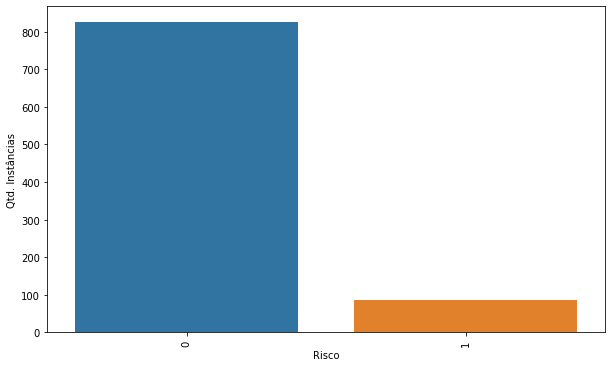

In [ ]:
# Checando se o dataset está desbalanceado
disease_counts = data['risco'].value_counts()
temp_df = pd.DataFrame({
    "Risco": disease_counts.index,
    "Qtd. Instâncias": disease_counts.values
})

print(data['risco'].value_counts())
sns.barplot(x = 'Risco', y = 'Qtd. Instâncias', data = temp_df)
plt.xticks(rotation = 90)
plt.show()

## Dividindo os dados em variáveis de entrada e resultado

In [ ]:
X = data.drop('risco', axis = 1)
y = data['risco']

## Continuando no pré-processamento
### _O pré-processamento é uma das etapas mais importantes do machine learning. Agora será realizado uma padronização nos valores das colunas. Variáveis ​​que estão em diferentes escalas não contribuem igualmente para o ajuste do modelo e função aprendida do modelo e podem acabar criando um viés._

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Dividindo o dataset em dados de treinamento e dados de teste
### _Aqui, teremos que os dados de teste será 10% do dataset._

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify = y, test_size = 0.10, random_state = 42)

## Criando a Random Forest para classificação
### _Utilizaremos um número de árvores igual a cem para a floresta, pesos para as classes por conta do desbalanceamento e mudança do critério de divisão._

In [ ]:
# Criando a instância do classificador
classifier = RandomForestClassifier(criterion = 'entropy', n_estimators = 100)

# Criando a instância do classificador com peso para os riscos (por conta do desbalanceamento das classes)
#peso = {0: 0.15, 1: 0.85}
#classifier = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, class_weight = peso)

# Treinando o classificador
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [ ]:
# Balanceamento utilizando SMOTE
# A SMOTE (técnica de sobreamostragem minoritária sintética) é uma técnica estatística para aumentar 
# o número de casos em seu conjunto de um modo equilibrado. O componente funciona gerando novas 
# instâncias de casos minoritários existentes que você fornece como entrada. Essa implementação 
#de SMOTE não muda o número de casos majoritários.
sm = SMOTE(k_neighbors = 85, random_state = 42)
X_up, y_up = sm.fit_resample(X.astype('float'), y)

# Separação entre dados de treino e teste
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size = 0.10, random_state = 42)

# Informações do antes e depois da sobreamostragem
print('\nAntes do OverSampling, quantidade de labels "1": {} instâncias.'.format(sum(y==1)))
print('Antes do OverSampling, quantidade de labels "0": {} instâncias.\n'.format(sum(y==0)))

print('\nDepois do OverSampling, quantidade de labels "1": {} instâncias.'.format(sum(y_up==1)))
print('Depois do OverSampling, quantidade de labels "0": {} instâncias.\n\n'.format(sum(y_up==0)))

# # Criando a instância do classificador com ajuste SMOTE (por conta do desbalanceamento das classes)
classifier_up = RandomForestClassifier(criterion = 'entropy', n_estimators = 100)
classifier_up = classifier_up.fit(X_train_up, y_train_up)
y_pred_up = classifier_up.predict(X_test_up)


Antes do OverSampling, quantidade de labels "1": 86 instâncias.
Antes do OverSampling, quantidade de labels "0": 826 instâncias.


Depois do OverSampling, quantidade de labels "1": 826 instâncias.
Depois do OverSampling, quantidade de labels "0": 826 instâncias.




## Realizando a previsão usando o classificador treinando nos dados de teste

In [ ]:
y_pred = classifier.predict(X_test)
y_pred_up = classifier_up.predict(X_test_up) # SMOTE

## Verificando a precisão usando valores reais e previstos a partir dos dados do teste.

In [ ]:
# Calculando a acurácia do classificador
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy} ou, aproximadamente, {round((accuracy * 100), 2)}%")

accuracy_up = accuracy_score(y_test_up, y_pred_up)
print(f"Acurácia SMOTE: {accuracy} ou, aproximadamente, {round((accuracy * 100), 2)}%")

Acurácia: 1.0 ou, aproximadamente, 100.0%
Acurácia SMOTE: 1.0 ou, aproximadamente, 100.0%


## Visualizando as características mais relevantes levadas em conta pelo classificador.

           Coluna  Importância
1       pas(mmHg)     0.563702
3  glicose(mg/dL)     0.205576
2       pad(mmHg)     0.205072
0           idade     0.025650 




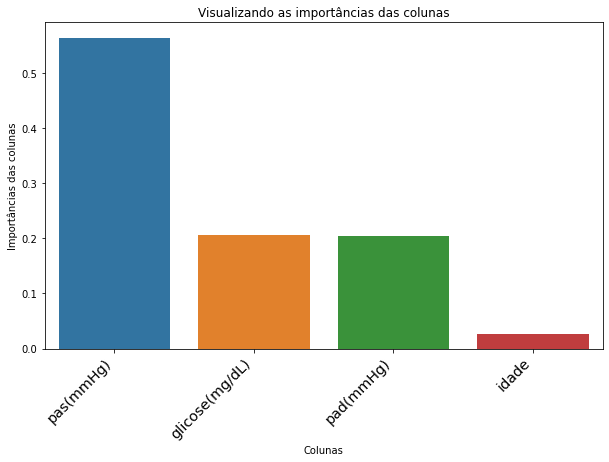

In [ ]:
feature_importances_data = pd.DataFrame(
                                        {
                                            'Coluna': list(X.columns),
                                            'Importância': classifier.feature_importances_
                                        }).sort_values('Importância', ascending = False)

print(feature_importances_data, '\n\n')

# Gráfico das importâncias
sns.barplot(x = feature_importances_data.Coluna, y = feature_importances_data.Importância)
plt.ylabel("Importâncias das colunas")
plt.xlabel("Colunas")
plt.title('Visualizando as importâncias das colunas')
plt.xticks(rotation = 45, horizontalalignment = "right", fontweight = "light", fontsize = "x-large")
plt.show()

## Visualizando as características mais relevantes levadas em conta pelo classificador (SMOTE).

           Coluna  Importância
1       pas(mmHg)     0.613872
2       pad(mmHg)     0.240257
3  glicose(mg/dL)     0.136314
0           idade     0.009557 




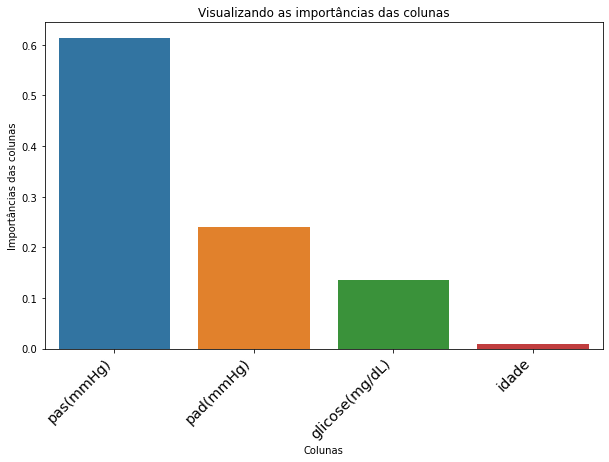

In [ ]:
feature_importances_data_up = pd.DataFrame(
                                        {
                                            'Coluna': list(X.columns),
                                            'Importância': classifier_up.feature_importances_
                                        }).sort_values('Importância', ascending = False)

print(feature_importances_data_up, '\n\n')

# Gráfico das importâncias
sns.barplot(x = feature_importances_data_up.Coluna, y = feature_importances_data_up.Importância)
plt.ylabel("Importâncias das colunas")
plt.xlabel("Colunas")
plt.title('Visualizando as importâncias das colunas')
plt.xticks(rotation = 45, horizontalalignment = "right", fontweight = "light", fontsize = "x-large")
plt.show()

## Exportando o modelo criado

In [ ]:
# Salvando o modelo treinado com dataset sobreamostrado com SMOTE
joblib.dump(classifier_up, "./random_forest_up.joblib")


# to load, no need to initialize the loaded_rf
#loaded_rf = joblib.load("./random_forest.joblib")

['./random_forest_up.joblib']

## Outros pontos que podem ser vistos com um dataset real (do PEC, por exemplo).
1. Uso do PCA (Principal component analysis) para redução de dimensionalidade.
    - Este algoritmo provê redução de dimensionalidade. Algumas vezes você tem
      uma grande quantidade de características, provavelmente muito
      correlacionadas entre si, e os modelos podem facilmente serem
      sobreajustados em um grande conjunto de dados.

2. Verificar a correlação entre as colunas.